## Model Development & Performance

In [1]:
import pandas as pd
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import copy

from sklearn.ensemble import RandomForestRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

#### Data Loading

In [36]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')

We will start with classic models to evaluate their effectiveness. As a first step, we will attempt to predict the number of people without power. Initially, we will remove columns that are not relevant to our task, such as time-related data and precise location identifiers (e.g., county name and code). The remaining data will be transformed and prepared for modeling.

### XGBRegressor

In [31]:
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind',]

In [5]:
target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division']
event_features = [col for col in df.columns if col in event_names]

X = df[numeric_features + categorical_features + event_features]
y = df[target]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

event_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('event', event_transformer, event_features)
])

In [8]:
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)

In [29]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    verbosity=1,
    colsample_bytree=0.3,
    early_stopping_rounds=20,
    random_state=42
)

xgb.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    verbose=True
)

[0]	validation_0-rmse:1479.44628
[1]	validation_0-rmse:1478.76089
[2]	validation_0-rmse:1478.22730
[3]	validation_0-rmse:1477.31792
[4]	validation_0-rmse:1476.28734
[5]	validation_0-rmse:1476.25554
[6]	validation_0-rmse:1474.07049
[7]	validation_0-rmse:1473.13567
[8]	validation_0-rmse:1472.70791
[9]	validation_0-rmse:1472.28972
[10]	validation_0-rmse:1471.00776
[11]	validation_0-rmse:1470.85316
[12]	validation_0-rmse:1469.18733
[13]	validation_0-rmse:1468.38280
[14]	validation_0-rmse:1468.30442
[15]	validation_0-rmse:1467.59923
[16]	validation_0-rmse:1465.09802
[17]	validation_0-rmse:1464.53772
[18]	validation_0-rmse:1464.02536
[19]	validation_0-rmse:1463.91608
[20]	validation_0-rmse:1463.74474
[21]	validation_0-rmse:1463.73358
[22]	validation_0-rmse:1462.90520
[23]	validation_0-rmse:1461.81601
[24]	validation_0-rmse:1461.37282
[25]	validation_0-rmse:1461.28740
[26]	validation_0-rmse:1461.27876
[27]	validation_0-rmse:1461.05672
[28]	validation_0-rmse:1461.04833
[29]	validation_0-rmse:1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [12]:
# Model XGBoost
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=2
)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.001, 0.5),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1,
    random_state=42
)

random_search.fit(X_train_proc, y_train)

with open("random_search_results.pkl", "wb") as f:
    pickle.dump(random_search, f)

print("✅ Zapisano RandomizedSearchCV do pliku random_search_results.pkl")
print("✅ Najlepsze parametry:", random_search.best_params_)
print("📉 Najlepszy neg-RMSE (cross-val):", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.4763571532049581, max_depth=5, n_estimators=171, subsample=0.8795975452591109; total time=  54.1s
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.4763571532049581, max_depth=5, n_estimators=171, subsample=0.8795975452591109; total time=  49.4s
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.4763571532049581, max_depth=5, n_estimators=171, subsample=0.8795975452591109; total time=  44.3s
[CV] END colsample_bytree=0.7468055921327309, learning_rate=0.07899726016810132, max_depth=5, n_estimators=187, subsample=0.8001125833417065; total time=  56.7s
[CV] END colsample_bytree=0.7468055921327309, learning_rate=0.07899726016810132, max_depth=5, n_estimators=187, subsample=0.8001125833417065; total time=  52.6s
[CV] END colsample_bytree=0.7468055921327309, learning_rate=0.07899726016810132, max_depth=5, n_estimators=187, subsample=0.8001125833417

In [15]:
best_model = random_search.best_estimator_
joblib.dump(best_model, "../models/xgb_model.pkl")
print("✅ Zapisano najlepszy model XGBoost do best_xgb_model.pkl")

✅ Zapisano najlepszy model XGBoost do best_xgb_model.pkl


In [19]:
y_pred = best_model.predict(X_val_proc)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 1414.8726
MAE: 91.6789
R²: 0.0882


As expected, the simplest model struggled to accurately estimate the target values, explaining only around 8% of the variance (R² = 0.0882). We are aware of the complexity and high noise level within the data, so such a result was anticipated. Moving forward, we will explore more advanced modeling approaches to improve performance.

### Time Series Modelling

Another model we are testing is the SARIMAX model, which is used for time series forecasting. It is particularly important as it allows us to account for both seasonal effects and exogenous variables. Since our data is aggregated on a daily basis, we can evaluate how well this model performs with such a frequency.

This model takes time as an input, but time is not unique in our dataset, since we are analyzing power outages separately for each county—this means that the same dates appear multiple times. The idea is to group dataset by county and analyse it separately.

The predicted variable will be PercentCustomersOut, which represents the number of people without power divided by the total population in the county. This metric better reflects differences between counties, as one county may be significantly larger than others.

In [2]:
df = pd.read_csv("C:\\Users\\HP\\Downloads\\modelingDataFrame\\modelingDataFrame.csv")

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[~df['Date'].dt.year.isin([2014, 2015, 2016, 2017, 2018])]
data_splits = {}
grouped = df.groupby(['StateName', 'CountyName'])

We will split the DataFrame into training and testing sets. Since our goal is to make early predictions, we will use the most recent year (i.e., the last 365 days) as the test set.

In [11]:
for (state, county), group in grouped:
    group = group.sort_values('Date').reset_index(drop=True)
    
    if len(group) > 1600:
        df_train = group.iloc[:-365]
        df_test = group.iloc[-365:]
    else:
        pass
    
    key = f"{state}_{county}"
    data_splits[key] = [df_train, df_test]

We are now transforming or removing the following columns:

- FIPS, Month, Year, Region, Division, lng_rad, lat_rad, StateName, CountyName – these columns contain only one unique value per county and therefore do not add value for modeling.

- Month and Year – these will be removed since we will use the date column to model seasonality.

- ValidDataFlag 


The following transformations will be applied:

- season – this is a categorical variable and will be one-hot encoded into binary features.

Finally, we will sort the data by the date column and set it as the index of the DataFrame.

In [12]:
for key, (df_train, df_test) in data_splits.items():

    col_to_stay = ['Date', 'CountyName', 
                      'StateName', 'PercentCustomersOut', 'Season', 'Tmin',
       'Tmax', 'Tavg', 'Ppt',  'Flood', 'Winter Weather', 'Heavy Rain', 'Strong Wind', 'Flash Flood', 'Heavy Snow', 'Thunderstorm Wind', 'Excessive Heat', 'Winter Storm', 'Drought', 'Tornado', 'Hail', 'Heat', 'High Wind']
    if not df_train.empty:
        df_train = df_train[[col for col in col_to_stay if col in df_train.columns]]
        
        df_train = pd.get_dummies(df_train, columns=['Season'])
        df_train['Date'] = pd.to_datetime(df_train['Date'], errors='coerce')
        df_train = df_train.sort_values('Date')
        df_train.set_index('Date', inplace=True)
        df_train = df_train.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

    if not df_test.empty:
        df_test = df_test[[col for col in col_to_stay if col in df_test.columns]]
        
        df_test = pd.get_dummies(df_test, columns=['Season'])
        df_test['Date'] = pd.to_datetime(df_test['Date'], errors='coerce')
        df_test = df_test.sort_values('Date')
        df_test.set_index('Date', inplace=True)
        df_test = df_test.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

    data_splits[key] = [df_train, df_test]


Since we have two possible target columns (PercentCustomersOut and CustomersOut), we will compare the results obtained using each of them to evaluate which one yields better performance.

In [13]:
dict_percent_customers_out = copy.deepcopy(data_splits)

The Augmented Dickey-Fuller (ADF) Test is a statistical test used to determine whether a time series is stationary or not. A stationary series has constant statistical properties such as mean, variance, and autocorrelation over time. The ADF test works by testing the null hypothesis that a unit root is present in the time series, which would imply the series is non-stationary (i.e., it has a trend or random walk behavior). If the test statistic is significantly negative and the p-value is low (usually less than 0.05), we reject the null hypothesis and conclude that the series is stationary.

In [14]:
non_stationary_keys = []
constant_keys = []

all_keys = list(dict_percent_customers_out.keys())

for idx, (key, d) in enumerate(dict_percent_customers_out.items()):
    series = d[1]['PercentCustomersOut']
    
    if series.nunique() == 1:
        print(f"{key} has constant values. Skipping ADF test.")
        constant_keys.append(key)
        continue
    
    result = adfuller(series)
    if idx < 2:
        print('ADF Statistic for ' + key + ': ' + str(result[0]))
        print('p-value for ' + key + ': ' + str(result[1]))
        print('------------------------------------------------')

    p_value = result[1]
    if p_value > 0.05:
        print(f'{key} is NOT stationary!')
        non_stationary_keys.append(key)

if not non_stationary_keys:
    print('All non-constant counties are stationary!')
else:
    print('Counties that are not stationary:', non_stationary_keys)

if constant_keys:
    print('Counties with constant PercentCustomersOut:', constant_keys)


ADF Statistic for Alabama_Autauga: -13.574866367245829
p-value for Alabama_Autauga: 2.1793846437174594e-25
------------------------------------------------
ADF Statistic for Alabama_Baldwin: -14.528043728451822
p-value for Alabama_Baldwin: 5.388024435398192e-27
------------------------------------------------
Arkansas_Jefferson is NOT stationary!
California_Trinity has constant values. Skipping ADF test.
Colorado_Morgan is NOT stationary!
Colorado_Weld is NOT stationary!
Georgia_Terrell is NOT stationary!
Illinois_Jefferson is NOT stationary!
Maine_Franklin is NOT stationary!
Maine_Kennebec is NOT stationary!
Maine_Oxford is NOT stationary!
Missouri_Atchison is NOT stationary!
Missouri_Boone is NOT stationary!
Missouri_Stone is NOT stationary!
Missouri_Sullivan is NOT stationary!
Missouri_Washington is NOT stationary!
New Hampshire_Carroll is NOT stationary!
North Carolina_Graham has constant values. Skipping ADF test.
North Carolina_Haywood has constant values. Skipping ADF test.
Nort

In [15]:
for key in non_stationary_keys:
    if key in dict_percent_customers_out and len(dict_percent_customers_out[key]) > 1:
        df = dict_percent_customers_out[key][1]

        diff_series = df['PercentCustomersOut'].diff()
        df = df.iloc[1:, :].copy()
        df['PercentCustomersOut'] = diff_series.dropna()

        dict_percent_customers_out[key][1] = df


#### Interpretation:

If p-values are smaller than 0.05, it means that for each of these counties, we can reject the null hypothesis of non-stationarity in the time series. Practically, this indicates that the data is stationary and can be used for analysis, modeling, and forecasting without the need for additional transformations such as removing trends or seasonality.



- Almost all values of the ADF test statistics are negative, indicating that we can confidently reject the null hypothesis of non-stationarity for most counties. For the few counties that were initially non-stationary, we applied differencing to transform them into stationary series. As a result, all time series are now stationary, with no significant trend or unit root present.

### ACF and PACF Plots

**Purpose:**
- **ACF (Autocorrelation Function)** and **PACF (Partial Autocorrelation Function)** plots are used to analyze the autocorrelations in a time series.
- ACF measures the correlation between a time series and its lagged values over different periods.
- PACF shows the partial correlation, which measures the correlation between the series and its lag, after removing the effects of shorter lags.

- **ACF Plot:** If the ACF shows a sharp cutoff, it suggests an MA process of a certain order.
- **PACF Plot:** A sharp cutoff in the PACF plot indicates the order of the AR component.


In [21]:
import random

def plot_acf_pacf_random(dict_data, lag, col='PercentCustomersOut', n_samples=5):
    plt.figure(figsize=(14, 10))
    
    sampled_keys = random.sample(list(dict_data.keys()), n_samples)

    for i, key in enumerate(sampled_keys, 1):
        d = dict_data[key]
        train = d[1]

        plt.subplot(n_samples, 2, 2 * i - 1)
        plot_acf(train[col], lags=lag, ax=plt.gca())
        plt.title(f"ACF - {key}")

        plt.subplot(n_samples, 2, 2 * i)
        plot_pacf(train[col], lags=lag, ax=plt.gca(), method='ywm')
        plt.title(f"PACF - {key}")

    plt.tight_layout()
    plt.show()

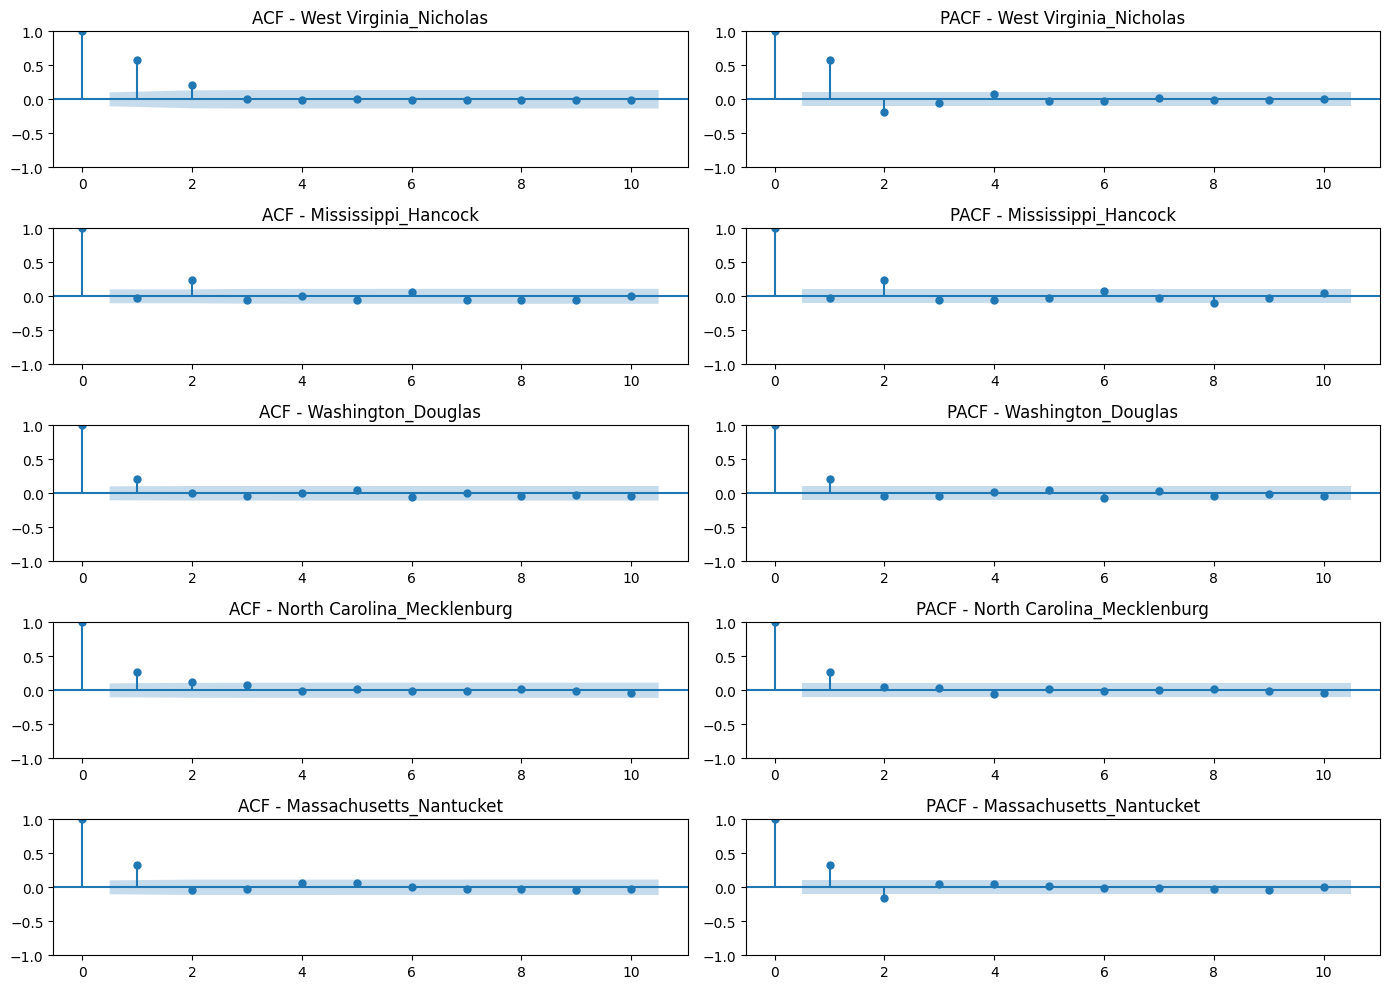

In [22]:
plot_acf_pacf_random(dict_percent_customers_out, 10)

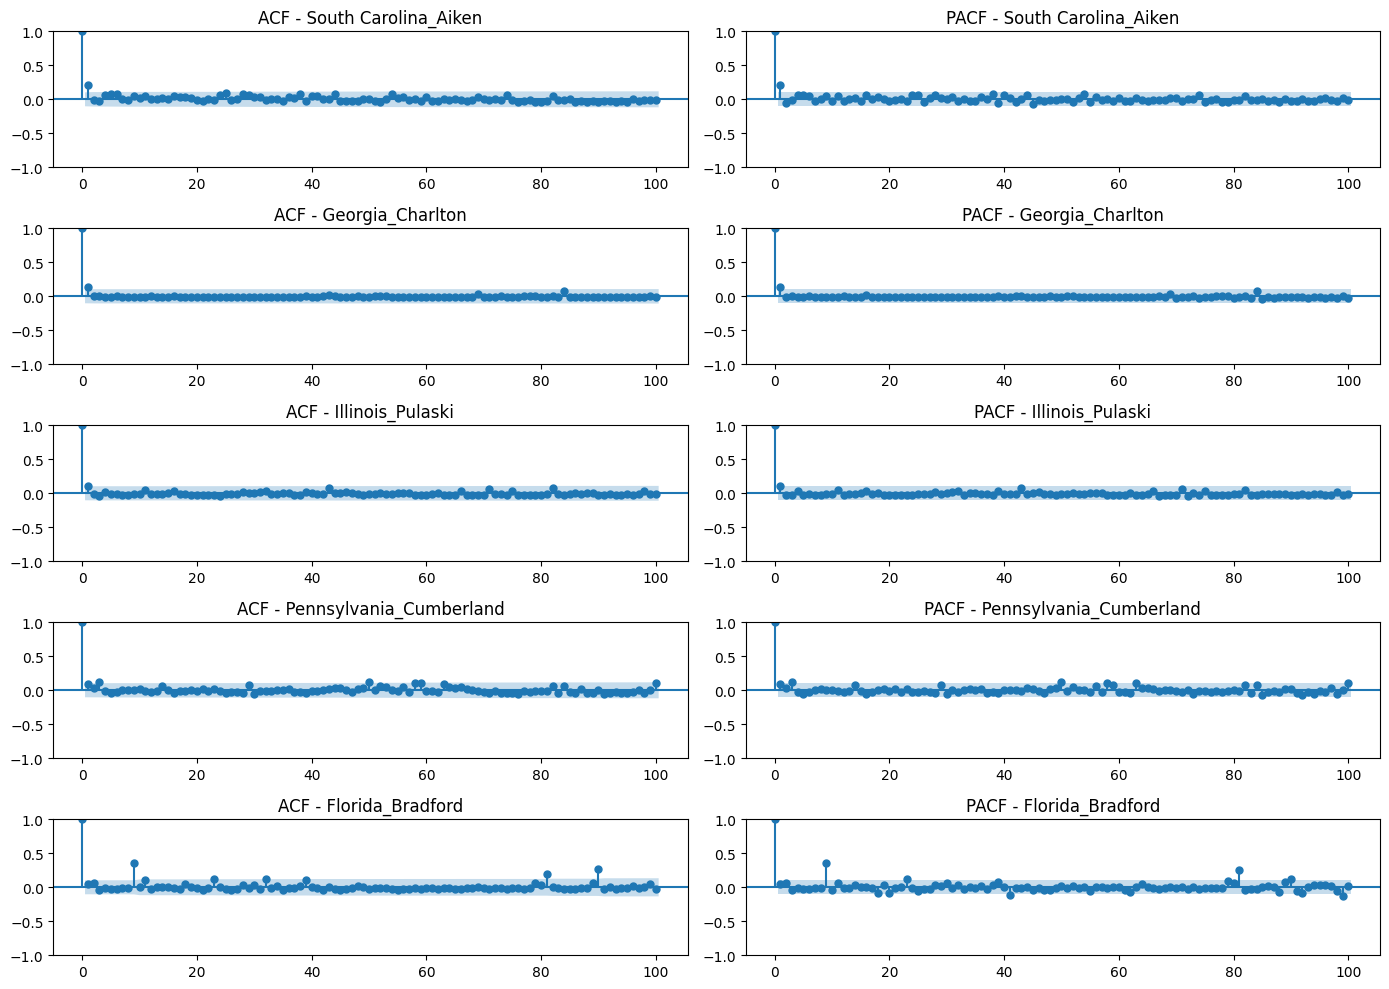

In [23]:
plot_acf_pacf_random(dict_percent_customers_out, 100)

- In this case, for all counties, the ACF plots show a sharp drop after a few lags. This suggests that most of the correlation in the series is captured by the initial few lags. After that, the correlation quickly diminishes, indicating short-range dependence
- the series has little memory
- PACF has a significant peak at lag 1, suggesting that an AR(1) process might also be a reasonable starting point for these counties

In [16]:
q = 1
p = 1
dd = 0

#### models

In [17]:
dict_copy = copy.deepcopy(dict_percent_customers_out)

In [24]:
for key, (train, test) in dict_copy.items():
    cols_to_remove = ['StateName', 'CountyName']

    train = train.drop(columns=cols_to_remove, errors='ignore')
    test = test.drop(columns=cols_to_remove, errors='ignore')
    dict_copy[key] = [train, test]


In [28]:
print(len(dict_copy))

2955


In [31]:
for key, d in dict_copy.items():
    try:
        train = d[0]
        test = d[1]

        train = train[~train.index.duplicated()]
        test = test[~test.index.duplicated()]

        train.index = pd.to_datetime(train.index)
        test.index = pd.to_datetime(test.index)

        print(f"Last date in training for {key}: {train.index[-1]}")

        model = SARIMAX(
            train['PercentCustomersOut'],
            exog=train.drop(columns='PercentCustomersOut'),
            order=(p, dd, q), 
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        results = model.fit(disp=False)

        n_test = len(test)
        forecast_results = results.get_forecast(steps=n_test, exog=test.drop(columns='PercentCustomersOut'))

        forecast = forecast_results.predicted_mean

        dict_copy[key].append(results)
        dict_copy[key].append(forecast)
        
    except Exception as e:
        print(f"Error processing {key}: {e}")
        continue

Last date in training for Alabama_Autauga: 2022-12-31 00:00:00
Last date in training for Alabama_Baldwin: 2023-01-01 00:00:00
Last date in training for Alabama_Barbour: 2022-12-31 00:00:00
Last date in training for Alabama_Bibb: 2023-01-01 00:00:00
Last date in training for Alabama_Blount: 2023-01-04 00:00:00
Last date in training for Alabama_Bullock: 2022-12-31 00:00:00
Last date in training for Alabama_Butler: 2023-02-01 00:00:00
Last date in training for Alabama_Calhoun: 2023-02-02 00:00:00
Last date in training for Alabama_Chambers: 2022-12-31 00:00:00
Last date in training for Alabama_Chilton: 2022-12-31 00:00:00
Last date in training for Alabama_Choctaw: 2023-01-03 00:00:00
Last date in training for Alabama_Clarke: 2023-01-11 00:00:00
Last date in training for Alabama_Clay: 2023-03-15 00:00:00
Last date in training for Alabama_Cleburne: 2023-01-01 00:00:00
Last date in training for Alabama_Coffee: 2023-01-08 00:00:00
Last date in training for Alabama_Conecuh: 2023-01-08 00:00:00


Now it it time for evaluating those models and compare them between counties. We will use rmse and mae metrics

In [46]:
results = {}
for key, d in dict_copy.items():
    if len(d) == 4:
        try:
            if len(d) == 4:
                test = d[1]
                forecast = d[3]
                test = test[~test.index.duplicated()]
                y_true = test.loc[forecast.index, 'PercentCustomersOut']

                mae = mean_absolute_error(y_true, forecast)
                rmse = np.sqrt(mean_squared_error(y_true, forecast))

                results[key] = [mae, rmse]
        except Exception as e:
            continue



In [48]:
df = pd.DataFrame([(key, *values) for key, values in results.items()], columns=['state_county', 'mae', 'rmse'])

In [54]:
mean_mae = df['mae'].mean()
mean_rmse = df['rmse'].mean()
print(mean_mae)
print(mean_rmse)

0.4557769041474929
1.385898658838184


Let's see which counties have the best and the worst values:

In [55]:
df.sort_values('mae')

,state_county,mae,rmse
1743,North Carolina_Swain,0.000000,0.000000
1701,North Carolina_Haywood,0.000000,0.000000
1712,North Carolina_Macon,0.000000,0.000000
1744,North Carolina_Transylvania,0.000000,0.000000
1695,North Carolina_Graham,0.000000,0.000000
...,...,...,...
1658,North Carolina_Alamance,6.199641,11.847988
2423,Texas_Presidio,7.819586,18.755436
2359,Texas_Jeff davis,10.338505,20.826480
1702,North Carolina_Henderson,33.680730,37.863865


Counties with very low metrics are counties where in training data there was no major power outages. models predicted 0 all the time and it was correct, but it does not mean that the model is working well. Due to lack of sifficient data in those couties we will skip them

In [57]:
df = df[df['mae'] > 0.1]

In [64]:
counties_to_visualise = np.array(df.sort_values('rmse').head(10)[['state_county']])

Let's visualise the counties with low rmse:

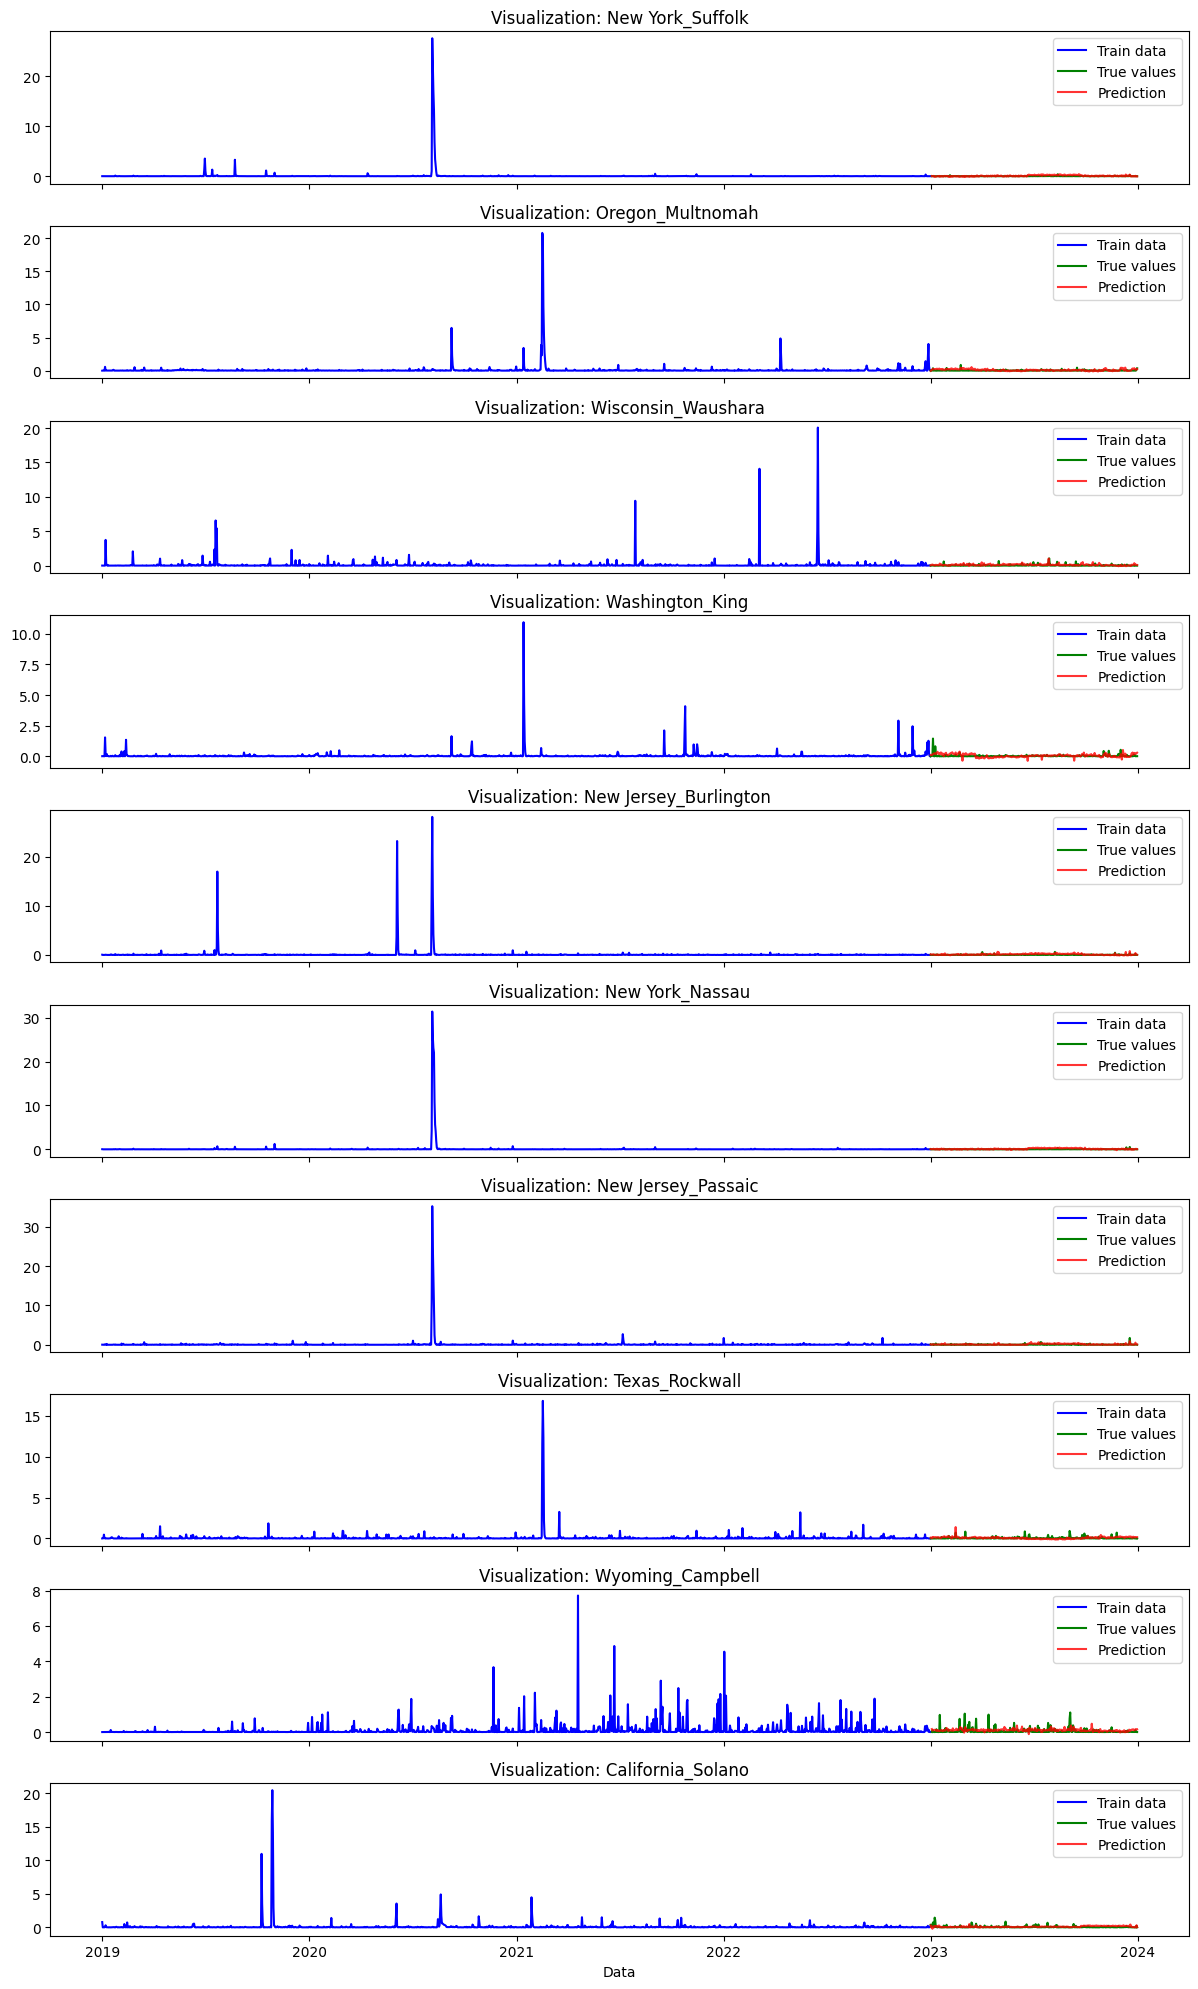

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20), sharex=True)
fig.subplots_adjust(hspace=0.4)

for ax, county in zip(axes, counties_to_visualise):

    row = dict_copy[county[0]]
    train = row[0]
    test = row[1]
    forecast = row[3]

    train = train[~train.index.duplicated()]
    test = test[~test.index.duplicated()]
        
    ax.plot(train.index, train['PercentCustomersOut'], label='Train data', color='blue')
    ax.plot(test.index, test['PercentCustomersOut'], label='True values', color='green')
    ax.plot(test.index, forecast, label='Prediction', color='red', alpha=0.8)
    ax.set_title(f'Visualization: {county[0]}')
    #ax.set_ylim(0, maxlim)
    ax.legend()

    plt.xlabel("Data")
plt.tight_layout()
plt.show()

And counties with the highest rmse:

In [75]:
counties_to_visualise = np.array(df.sort_values('rmse').tail(10)[['state_county']])

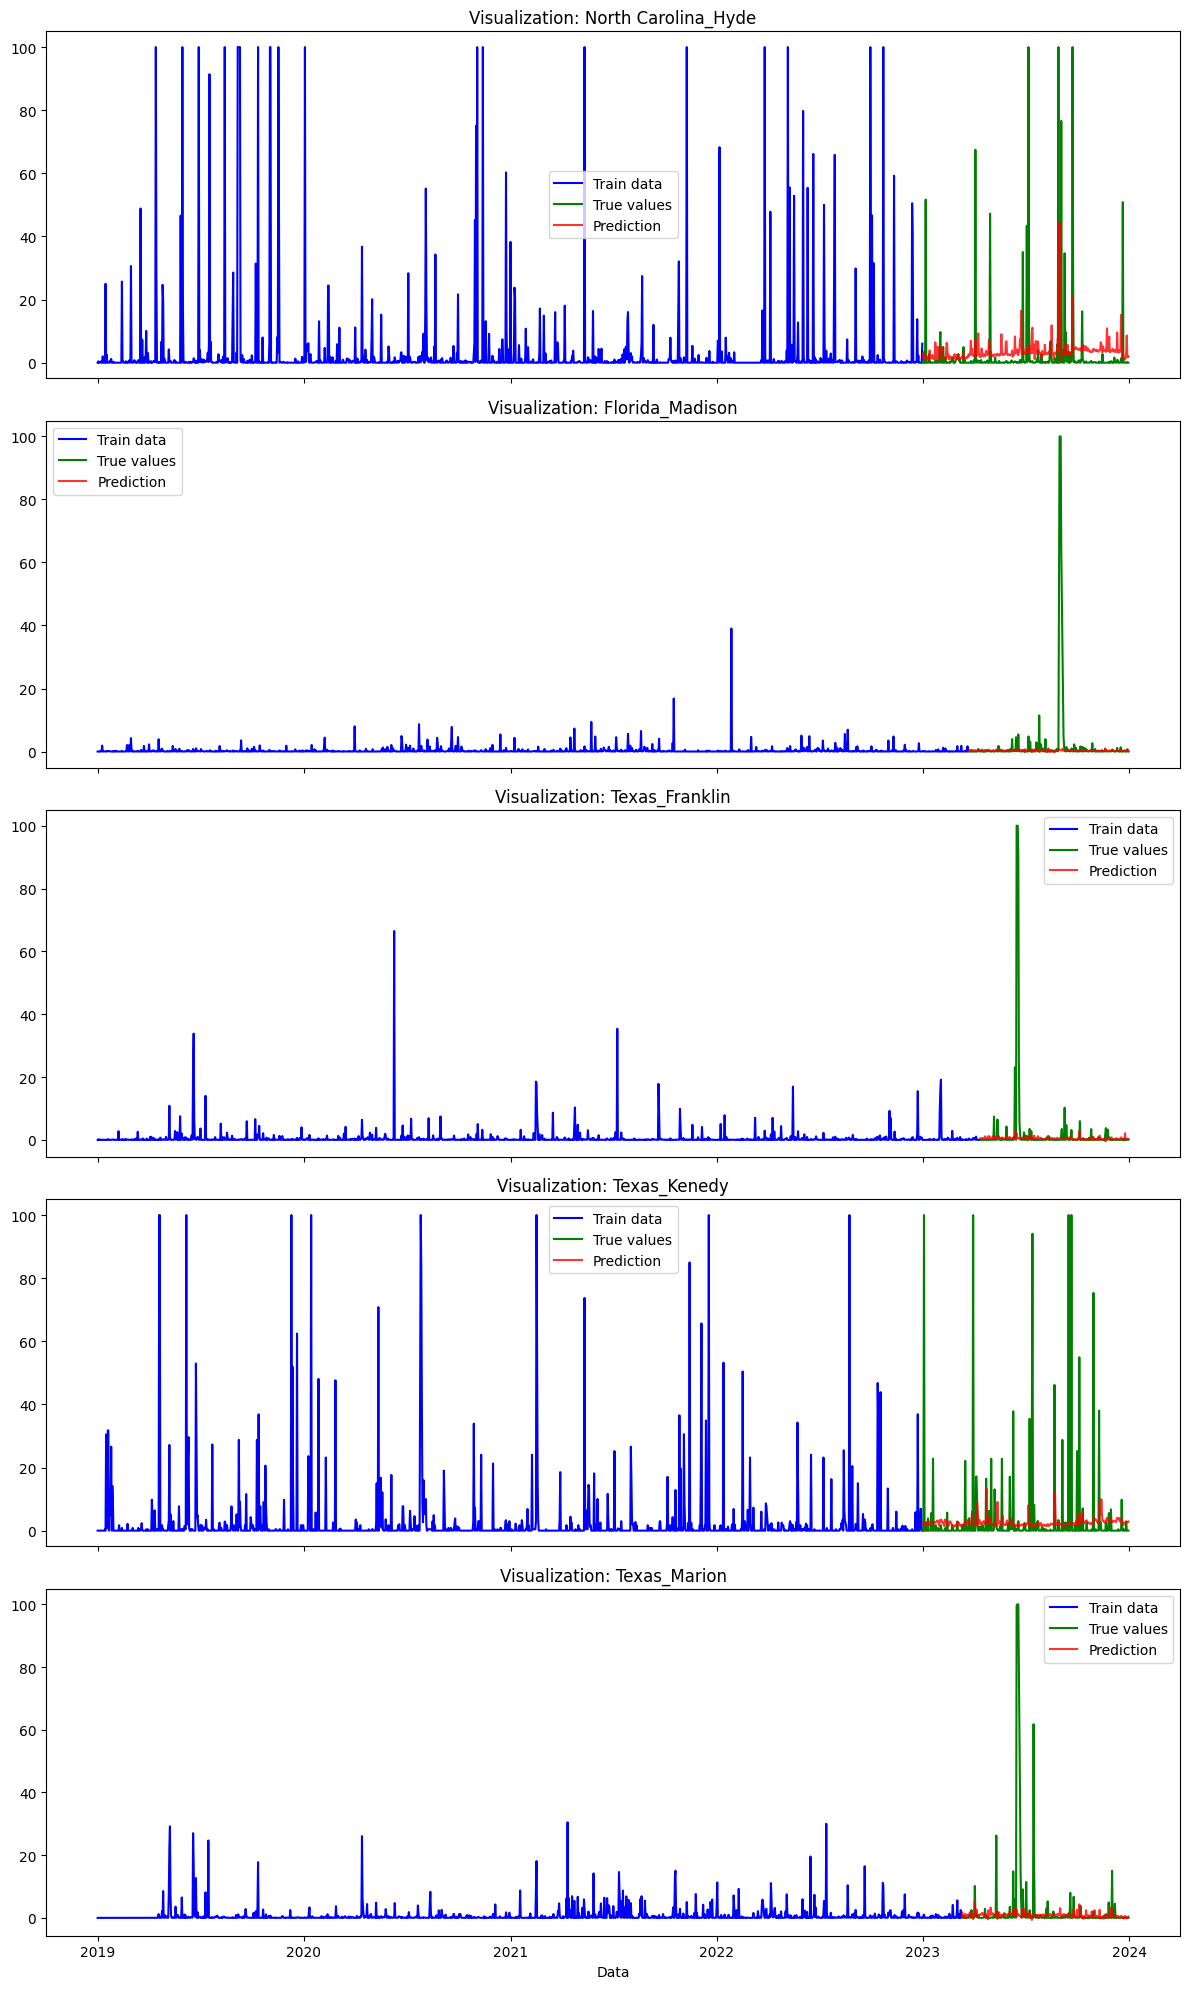

In [77]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20), sharex=True)
fig.subplots_adjust(hspace=0.4)

for ax, county in zip(axes, counties_to_visualise):

    row = dict_copy[county[0]]
    train = row[0]
    test = row[1]
    forecast = row[3]

    train = train[~train.index.duplicated()]
    test = test[~test.index.duplicated()]
        
    ax.plot(train.index, train['PercentCustomersOut'], label='Train data', color='blue')
    ax.plot(test.index, test['PercentCustomersOut'], label='True values', color='green')
    ax.plot(test.index, forecast, label='Prediction', color='red', alpha=0.8)
    ax.set_title(f'Visualization: {county[0]}')
    #ax.set_ylim(0, maxlim)
    ax.legend()

    plt.xlabel("Data")
plt.tight_layout()
plt.show()

The key takeaway is that we cannot directly compare the RMSE metrics across different counties. Counties that experience frequent or major power outages tend to have much higher RMSE values because models struggle to accurately predict these large-scale events. Conversely, when a model shows a low RMSE, it often indicates that there were no major power outages between 2019 and 2024, making the prediction task much easier. In the interpretability section, however, we will still compare models with both high and low RMSE scores to better understand how they perform, why they produce certain results, and which features are the most influential in their predictions.

### TabNet

In [32]:
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind']

In [38]:
df.shape

(8323937, 57)

Due to the high computational demands of TabNet, we had to limit both the dataset size and adjust the network parameters. We are using only the rows that we previously identified as "trustworthy" during the feature engineering stage, and we are selecting weather event columns that are expected to contribute the most valuable information.

In [39]:
df = df[df['ValidDataFlag'] == 1]
df.shape

(3240255, 57)

In [53]:
df['Year'].value_counts()
df = df[~df['Year'].isin([2015, 2016, 2017])]
df.shape

(2701153, 57)

In [33]:
zero_percentages = {}

for col in event_names:
    if col in df.columns:
        zero_count = (df[col] == 0).sum()
        total_count = len(df)
        zero_percentage = (zero_count / total_count) * 100
        zero_percentages[col] = zero_percentage

zero_percentages_df = pd.DataFrame.from_dict(zero_percentages, orient='index', columns=['%_zero'])
zero_percentages_df = zero_percentages_df.sort_values('%_zero', ascending=False)

display(zero_percentages_df)

,%_zero
Astronomical Low Tide,100.000000
Extreme Cold/Wind Chill,100.000000
Winter Weather,100.000000
High Surf,100.000000
Wildfire,100.000000
Heavy Rain,100.000000
Cold/Wind Chill,100.000000
Dense Fog,100.000000
Frost/Freeze,100.000000
Strong Wind,100.000000


In [34]:
selected_events_name = [
    col for col, perc in zero_percentages.items() if perc < 99.8
]

print(selected_events_name)

['Flood', 'Funnel Cloud', 'Thunderstorm Wind', 'Debris Flow', 'Hail']


In [51]:
target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division', 'Month', 'StateName', 'CountyName']
event_features = [col for col in df.columns if col in selected_events_name]

X = df[numeric_features + categorical_features + event_features]
y = df[target]

In [52]:
X.shape, y.shape

((2701153, 26), (2701153,))

In [54]:
X_encoded = X.copy()
for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [ ]:
model_TabNet = TabNetRegressor(
    n_d=16,            
    n_a=16,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

In [ ]:
model_TabNet.fit(
    X_train=X_train.values,
    y_train=y_train.values.reshape(-1,1),
    eval_set=[(X_test.values, y_test.values.reshape(-1,1))],
    eval_metric=["rmse"],
    max_epochs=10,
    patience=4,
    batch_size=4096,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 3460273.93356| val_0_rmse: 1954.44042|  0:05:42s
epoch 1  | loss: 3445467.56533| val_0_rmse: 1950.2747|  0:15:46s
epoch 2  | loss: 3447512.20995| val_0_rmse: 1950.97798|  0:25:46s
epoch 3  | loss: 3433010.06952| val_0_rmse: 1947.5803|  0:35:15s
epoch 4  | loss: 3416002.92128| val_0_rmse: 1935.06165|  0:44:11s
epoch 5  | loss: 3392685.07911| val_0_rmse: 1921.98469|  0:53:11s
epoch 6  | loss: 3376295.85399| val_0_rmse: 1932.97782|  1:02:50s
epoch 7  | loss: 3355619.75473| val_0_rmse: 1922.84166|  1:13:28s
epoch 8  | loss: 3345976.31067| val_0_rmse: 1920.99402|  1:24:14s
epoch 9  | loss: 3335282.37767| val_0_rmse: 1917.46909|  1:34:50s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_rmse = 1917.46909


In [59]:
model_TabNet.save_model('../models/tabnet_model')

Successfully saved model at ../models/tabnet_model.zip


'../models/tabnet_model.zip'

In [60]:
y_pred = model_TabNet.predict(X_test.values).flatten()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

MSE: 3676687.7208
RMSE: 1917.4691
R²: 0.0431


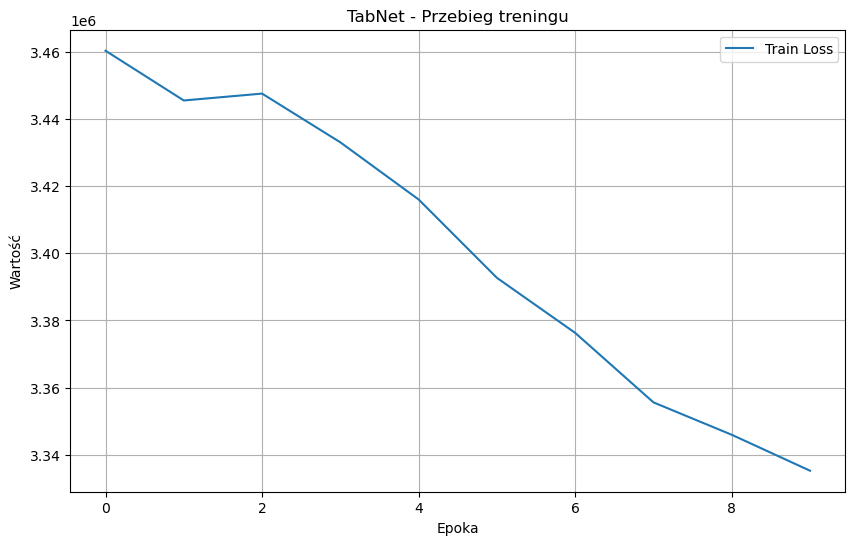

In [ ]:
train_loss = model_TabNet.history['loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
# plt.plot(valid_rmse, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TabNet - Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


Longer training

We will attempt to train the TabNet model again. Although the previous training did not yield the best results, we observed a very promising decrease in both loss and RMSE. We assume that a longer training process may help us achieve a better outcome. We are adjusting the training duration and diversifying the model architecture (while, of course, taking into account our computational limitations).

In [79]:
sample_frac = 0.1

sample_idx = np.random.choice(len(X_train), int(len(X_train) * sample_frac), replace=False)
X_sample = X_train.iloc[sample_idx]
y_sample = y_train.iloc[sample_idx]

X_train_small, X_val_small, y_train_small, y_val_small = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

In [83]:
param_grid = {
    'n_d': [16, 32],
    'n_a': [16, 32],
    'n_steps': [3, 5, 7],
    'gamma': [1.0, 1.5]
}

grid = list(product(*param_grid.values()))

In [81]:
def train_and_evaluate(X_train, y_train, X_val, y_val, params):
    model = TabNetRegressor(
        n_d=params['n_d'],
        n_a=params['n_a'],
        n_steps=params['n_steps'],
        gamma=params['gamma'],
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        verbose=1
    )
    model.fit(
        X_train=X_train.values,
        y_train=y_train.values.reshape(-1,1),
        eval_set=[(X_val.values, y_val.values.reshape(-1,1))],
        eval_metric=["rmse"],
        max_epochs=10,
        patience=3,
        batch_size=4096,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )
    preds = model.predict(X_val.values)
    rmse = mean_squared_error(y_val.values, preds, squared=False)
    return rmse

In [84]:
best_rmse = float('inf')
best_params = None

for values in grid:
    params = dict(zip(param_grid.keys(), values))
    print(f"Testing params: {params}")
    rmse = train_and_evaluate(X_train_small, y_train_small, X_val_small, y_val_small, params)
    print(f"RMSE: {rmse:.4f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("\nBest parameters found:")
print(best_params)
print(f"Best RMSE: {best_rmse:.4f}")

Testing params: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0}
epoch 0  | loss: 5472017.01989| val_0_rmse: 1581.56013|  0:00:40s
epoch 1  | loss: 5459390.40923| val_0_rmse: 1578.76356|  0:01:20s
epoch 2  | loss: 5450004.98245| val_0_rmse: 1579.36811|  0:01:56s
epoch 3  | loss: 5451716.98474| val_0_rmse: 1579.21782|  0:02:41s
epoch 4  | loss: 5449016.93197| val_0_rmse: 1578.61006|  0:03:27s
epoch 5  | loss: 5445539.40371| val_0_rmse: 1578.96193|  0:04:10s
epoch 6  | loss: 5443686.91298| val_0_rmse: 1577.58561|  0:04:54s
epoch 7  | loss: 5443509.16332| val_0_rmse: 1577.62899|  0:05:25s
epoch 8  | loss: 5440775.93659| val_0_rmse: 1578.31661|  0:05:53s
epoch 9  | loss: 5441087.69912| val_0_rmse: 1577.92144|  0:06:32s

Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_0_rmse = 1577.58561
RMSE: 1577.5856
Testing params: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5}
epoch 0  | loss: 5472048.17123| val_0_rmse: 1581.83487|  0:00:32s
epoch 1  | loss: 5457123.39279| val

In [86]:
model_TabNet_v2 = TabNetRegressor(
    n_d=32,            
    n_a=16,
    n_steps=3,
    gamma=1.0,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

In [ ]:
model_TabNet_v2.fit(
    X_train=X_train.values,
    y_train=y_train.values.reshape(-1,1),
    eval_set=[(X_train.values, y_train.values.reshape(-1,1)), 
     (X_test.values, y_test.values.reshape(-1,1))],
    eval_metric=["rmse"],
    max_epochs=100,
    patience=10,
    batch_size=4096,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 3457134.58037| val_0_rmse: 1857.26878| val_1_rmse: 1954.11536|  0:08:07s
epoch 1  | loss: 3447152.21128| val_0_rmse: 1853.31924| val_1_rmse: 1951.50246|  0:16:20s


In [ ]:
model_TabNet_v2.save_model('../models/tabnet_model_v2')